<strong>This is reproduction of the work by Pratyush Tiwary and Group following the same approach. You can visit their original <a href="https://github.com/tiwarylab/LSTM-predict-MD">Githut page</a> for more details.</strong>

<h3>Import Essential Basic Library</h3>

In [7]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib notebook
import os
import time

<h3> Data Preparation </h3>

<p> Download the data file from <a href="https://github.com/tiwarylab/LSTM-predict-MD/blob/master/xvyw1beta9.5gammax1.0gammay1.0epsln1.0sgma1.0A1.0x01.122w0.8B0.15a1.0_h0.01_mix1.txt"> here </a>, whose first second column contains <strong>time evolution of Collective Variable.</strong></p>

In [8]:
infile = 'xvyw1beta9.5gammax1.0gammay1.0epsln1.0sgma1.0A1.0x01.122w0.8B0.15a1.0_h0.01_mix1.txt.1'

In [9]:
input_x, input_y = np.loadtxt(infile, unpack=True, usecols=(0, 1), skiprows=1)

In [10]:
input_x

array([-2.02928, -2.17556, -2.21415, ...,  2.13755,  1.90849,  1.40443])

In [11]:
input_y

array([ 0.981566,  1.17552 ,  1.25237 , ..., -0.221278, -0.332399,
       -0.53323 ])

<p><strong>Define</strong> a function to calculate running average, averaging over N points.</p>
<p><strong>Follow</strong> <a href="https://numpy.org/doc/stable/reference/generated/numpy.convolve.html"> np.convolve </a> and <a href="https://en.wikipedia.org/wiki/Convolution"> Convolution</a>.

In [12]:
def running_mean(x, N):
    return np.convolve(x, np.ones((N,))/N, mode='valid')

<strong>Define</strong> the four states visited by MD of the 4 state model potential.

In [13]:
X=[2.0, 0.5, -0.5, -2.0]

In [14]:
input_x.shape

(1599999,)

In [15]:
time = np.arange(input_x.shape[0])

In [16]:
time.shape

(1599999,)

Plot CV as a function of time to check if the trajectory visits all the state points.

<IPython.core.display.Javascript object>


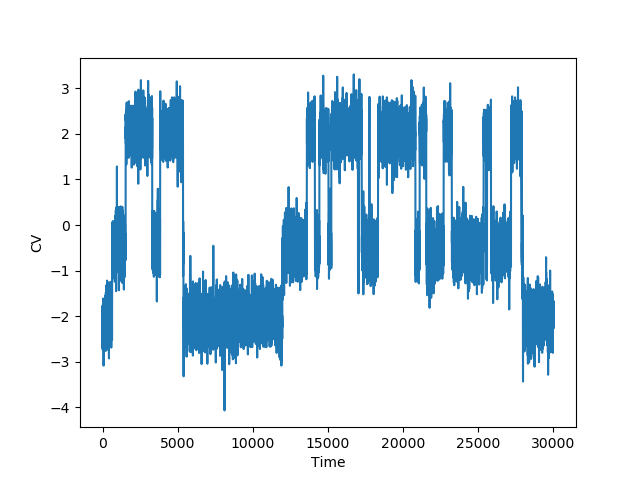

Text(0, 0.5, 'CV')

In [17]:
plt.plot(time[:30000], input_x[:30000])
plt.xlabel("Time")
plt.ylabel("CV")

<strong>Get</strong> the running average of the input to reduce the noise, and <strong>Plot</strong> to check.

In [18]:
input_x = running_mean(input_x, 50)

<IPython.core.display.Javascript object>


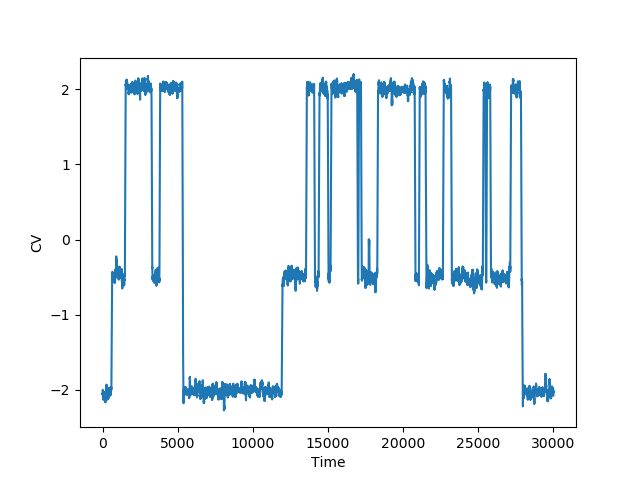

Text(0, 0.5, 'CV')

In [19]:
plt.plot(time[:30000], input_x[:30000])
plt.xlabel("Time")
plt.ylabel("CV")

<strong>Define</strong> a function to get the nearest state point and get its index.

In [20]:
def find_nearest(key_arr, target):
    idx = np.abs(key_arr-target).argmin()
    return idx

In [21]:
idx_x = map(lambda x: find_nearest(X,x), input_x)

In [22]:
idx_2d = list(idx_x)

In [23]:
traj = np.array(idx_2d)

In [24]:
traj

array([3, 3, 3, ..., 0, 0, 0])

In [30]:
traj.shape

(1599950,)

<IPython.core.display.Javascript object>


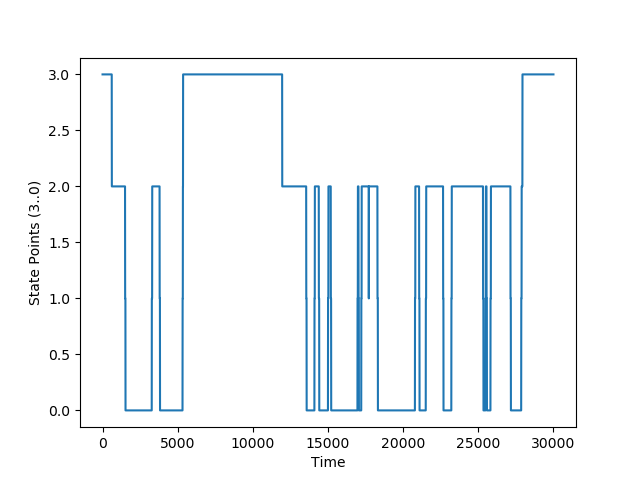

Text(0, 0.5, 'State Points (3..0)')

In [25]:
plt.plot(time[:30000], traj[:30000])
plt.xlabel("Time")
plt.ylabel("State Points (3..0)")

<strong>Generate</strong> the gradient to check sudden change in CV as well as non-zero gradient.

In [27]:
grad_traj = np.gradient(traj)

In [28]:
grad_traj

array([0., 0., 0., ..., 0., 0., 0.])

<IPython.core.display.Javascript object>


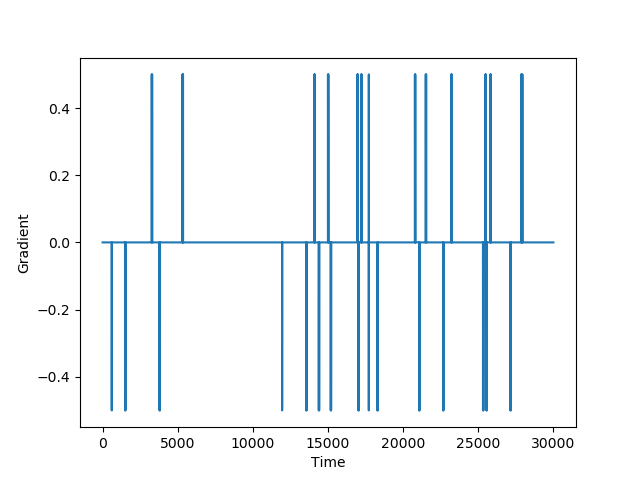

Text(0, 0.5, 'Gradient')

In [29]:
plt.plot(time[:30000], grad_traj[:30000])
plt.xlabel("Time")
plt.ylabel("Gradient")

Considering where gradient is non-zero.

In [31]:
idx_grad = np.where(grad_traj!=0)[0]

In [32]:
idx_grad.shape

(4902,)

In [33]:
idx_grad

array([    611,     612,    1496, ..., 1599754, 1599779, 1599780])

<strong>Define</strong> a function to remove sudden change in the CV. Have a look at State Point Vs Time plot. There are small irregurality in the plot. To remove such irregurality and making it smooth.

In [34]:
def Rm_peaks_steps(traj):
    traj=np.array(traj)
    grad_traj=np.gradient(traj)
    idx_grad=np.where(grad_traj!=0)[0]
    threshold=100
    idx0=idx_grad[0] #initialize idx0
    for idx in idx_grad:
        window=idx-idx0 
        if window <= 1: #neighbour
            continue
        elif window > 1 and window <= threshold: #within threshold
            traj[idx0:idx0+window//2+1]=traj[idx0] #make the first half to be traj[idx0]
            traj[idx0+window//2+1:idx+1]=traj[idx+1] #second half to be traj[idx+1]
            idx0=idx
        elif window > threshold:
            idx0=idx
    return traj

In [35]:
idx_2d = Rm_peaks_steps(idx_2d)

In [36]:
idx_2d

array([3, 3, 3, ..., 0, 0, 0])

<strong>Plot</strong> the State Point Vs Time graph again after smoothening.

<IPython.core.display.Javascript object>


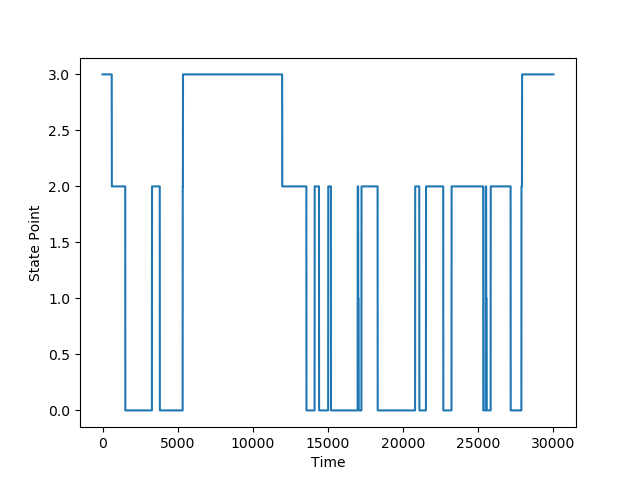

Text(0, 0.5, 'State Point')

In [37]:
plt.plot(time[:30000], idx_2d[:30000])
plt.xlabel("Time")
plt.ylabel("State Point")

<h4>Create a char2idx dictionary having {char:idx} and then convert the whole dataset.</h4>

In [39]:
text = idx_2d

In [40]:
num_bins = 4

In [41]:
all_combs = [i for i in range(num_bins)]

In [42]:
all_combs

[0, 1, 2, 3]

In [43]:
vocab = sorted(all_combs)

In [44]:
vocab

[0, 1, 2, 3]

In [45]:
char2idx = {u:i for i, u in enumerate(vocab)}

In [46]:
char2idx

{0: 0, 1: 1, 2: 2, 3: 3}

In [47]:
idx2char = np.array(vocab)

In [48]:
idx2char

array([0, 1, 2, 3])

In [49]:
text_as_int = np.array([char2idx[c] for c in text])

In [50]:
text_as_int

array([3, 3, 3, ..., 0, 0, 0])

Create a TensorFlow dataset

In [51]:
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

In [52]:
list(char_dataset.as_numpy_iterator())[:10]

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

Create examples per epoch to be used.

In [54]:
seq_length = 100
shift=1
examples_per_epoch = len(text)//(seq_length+shift)

<strong>Create</strong> batches with batch size=seq_length+size and drop remainder elements. Check <a href="https://www.tensorflow.org/api_docs/python/tf/data/Dataset"> documentation </a>.

In [56]:
sequences = char_dataset.batch(seq_length+shift, drop_remainder=True)

<strong>Define</strong> a function to create input and target.

In [61]:
def split_input_target(chunk):
    input_text = chunk[:-shift] #consider all elements except the last as input
    target_test = chunk[shift:] #consider all elements except the first as target
    return input_text, target_test

<strong>Create</strong> the Dataset having batches of input and target.

In [62]:
dataset = sequences.map(split_input_target)

In [63]:
dataset.as_numpy_iterator()

In [64]:
dataset

<MapDataset shapes: ((100,), (100,)), types: (tf.int64, tf.int64)>

Define buffer size and suffle the dataset

In [65]:
BATCH_SIZE = 64
steps_per_epoch = examples_per_epoch//BATCH_SIZE
BUFFER_SIZE = 50000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

<strong>Do the same</strong> for validation Data.

In [66]:
infile_v = 'xvyw1beta9.5gammax1.0gammay1.0epsln1.0sgma1.0A1.0x01.122w0.8B0.15a1.0_h0.01_mix1.txt.1'
input_xv, input_yv = np.loadtxt(infile_v, unpack=True, usecols=(0,1), skiprows=1)
input_xv = running_mean(input_xv, 50)
idx_xv = map(lambda x: find_nearest(X, x), input_xv)
idx_2dv=list(idx_xv)
idx_2dv = Rm_peaks_steps(idx_2dv)
vali = idx_2dv[:40000]
vali_as_int = np.array([char2idx[c] for c in vali])
vali_dataset = tf.data.Dataset.from_tensor_slices(vali_as_int)
sequences = vali_dataset.batch(seq_length+1, drop_remainder=True)
vdataset = sequences.map(split_input_target)
vdataset = vdataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
v_examples=len(vali_as_int)//(seq_length+shift)
v_steps_per_epoch=v_examples//BATCH_SIZE

<strong>Check availability of keras GPU version.</strong>

In [67]:
if tf.test.is_gpu_available():
    rnn = tf.keras.layers.CuDNNLSTM
else:
    import functools
    rnn = functools.partial(
    tf.keras.layers.LSTM, recurrent_activation='sigmoid')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


<h3>Build the LSTM Model</h3>

In [71]:
vocab_size = len(vocab)

In [72]:
embedding_dim = 8 
rnn_units = 64

In [73]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
        rnn(rnn_units, return_sequences=True, recurrent_initializer='glorot_uniform', stateful=True),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [74]:
model = build_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

In [75]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 8)             32        
_________________________________________________________________
lstm (LSTM)                  (64, None, 64)            18688     
_________________________________________________________________
dense (Dense)                (64, None, 4)             260       
Total params: 18,980
Trainable params: 18,980
Non-trainable params: 0
_________________________________________________________________


<strong>Import</strong> the lossT function defined by Tiwary group. You can download it from <a href="https://github.com/tiwarylab/LSTM-predict-MD/blob/master/lossT.py"> here</a>.

In [76]:
from lossT import sparse_categorical_crossentropy

In [77]:
def loss(labels, logits):
    return sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [78]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=loss)

In [79]:
EPOCHS=20

<strong><span class="birk">Create</strong> a directory to contain all the checkpoint files.</span>

In [80]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

<h3>Training</h3>

In [92]:
model.fit(dataset.repeat(EPOCHS), epochs=EPOCHS, steps_per_epoch=steps_per_epoch, validation_data=vdataset.repeat(EPOCHS), validation_steps=v_steps_per_epoch, callbacks=[checkpoint_callback])

Epoch 1/20
247/247 [==============================] - 16s 66ms/step - loss: 0.4343 - val_loss: 0.1284
Epoch 2/20
247/247 [==============================] - 16s 66ms/step - loss: 0.0946 - val_loss: 0.0627
Epoch 3/20
247/247 [==============================] - 16s 66ms/step - loss: 0.0465 - val_loss: 0.0310
Epoch 4/20
247/247 [==============================] - 16s 67ms/step - loss: 0.0242 - val_loss: 0.0169
Epoch 5/20
247/247 [==============================] - 16s 67ms/step - loss: 0.0137 - val_loss: 0.0117
Epoch 6/20
247/247 [==============================] - 16s 67ms/step - loss: 0.0099 - val_loss: 0.0101
Epoch 7/20
247/247 [==============================] - 16s 66ms/step - loss: 0.0085 - val_loss: 0.0093
Epoch 8/20
247/247 [==============================] - 16s 66ms/step - loss: 0.0080 - val_loss: 0.0088
Epoch 9/20
247/247 [==============================] - 16s 66ms/step - loss: 0.0077 - val_loss: 0.0091
Epoch 10/20
247/247 [==============================] - 16s 66ms/step - loss: 0.007

<h3>Build a model using the checkpoint file of last epoch</h3>

In [81]:
pmodel = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

In [82]:
pmodel.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

In [83]:
pmodel.build(tf.TensorShape([1, None]))

In [84]:
pmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 8)              32        
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 64)             18688     
_________________________________________________________________
dense_1 (Dense)              (1, None, 4)              260       
Total params: 18,980
Trainable params: 18,980
Non-trainable params: 0
_________________________________________________________________


<h3>Generate Trajectory using the learnt Model</h3>

In [87]:
infile_p = 'xvyw1beta9.5gammax1.0gammay1.0epsln1.0sgma1.0A1.0x01.122w0.8B0.15a1.0_h0.01_mix1.txt.1'

In [88]:
input_xp, input_yp = np.loadtxt(infile_p, unpack=True, usecols=(0, 1), skiprows=1)

In [89]:
idx_xp = map(lambda x: find_nearest(X, x), input_xp)
idx_2dp=list(idx_xp)
idx_2dp = Rm_peaks_steps(idx_2dp)
text = idx_2dp[:100000]

In [90]:
def generate(pmodel, start_string):
    num_generate = 1599950
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)
    text_generated = np.empty(1)
    pmodel.reset_states()
    for i in range(num_generate):
        start = time.time()
        predictions = pmodel(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predicted_id = tf.compat.v1.multinomial(predictions, num_samples=1)[-1, 0].numpy()
        input_eval = tf.expand_dims([predicted_id], 0)
        text_generated = np.vstack((text_generated, idx2char[predicted_id].tolist()))
        print(i)
    return text_generated

<div class="birk">
<span class="pirk">This will take around 3 hrs on 1 core CPU. It has already been done and saved in a file called "prediction.dat". So, I'll use predicted values from the file.</span></div><i class="fa fa-lightbulb-o "></i>

In [101]:
#start0 = time.time()
#prediction = generate(pmodel, start_string=text)
#print ('Time taken for total {} sec\n'.format(time.time() - start0))

In [91]:
prediction = np.genfromtxt('prediction.dat')

In [119]:
plt.figure?

<IPython.core.display.Javascript object>


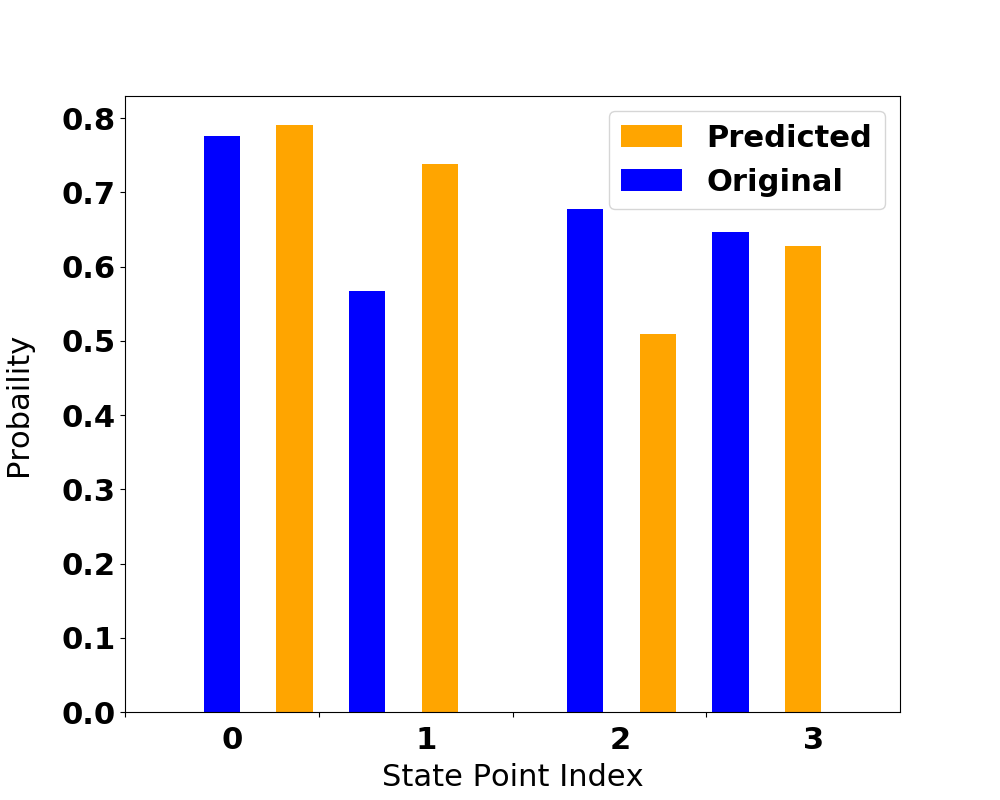

/home/sudarshan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/sudarshan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


Text(3, -0.05, '3')

In [138]:
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams.update({'font.size': 22, 'font.weight': "bold"})
plt.hist(prediction[1:], bins=8, normed=True, align='right', rwidth=0.5, color='orange', label="Predicted")
plt.hist(idx_2d, bins=8, normed=True, align='left', rwidth=0.5, color='blue', label="Original")
plt.legend()
plt.xticks(ticks=[-0.5, 0.5, 1.5, 2.5], labels=[])
plt.xlim(-0.5, 3.5)
plt.xlabel("State Point Index", labelpad=30)
plt.ylabel("Probaility", labelpad=20)
plt.text(0, -0.05, "0"); plt.text(1, -0.05, "1"); plt.text(2, -0.05, "2"); plt.text(3, -0.05, "3")

In [130]:
np.savetxt('prediction.dat', prediction[1:], fmt='%i')